# Imports

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from scipy.optimize import curve_fit
from string import ascii_uppercase
from utils import plot_side_by_side
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

# Background Extraction

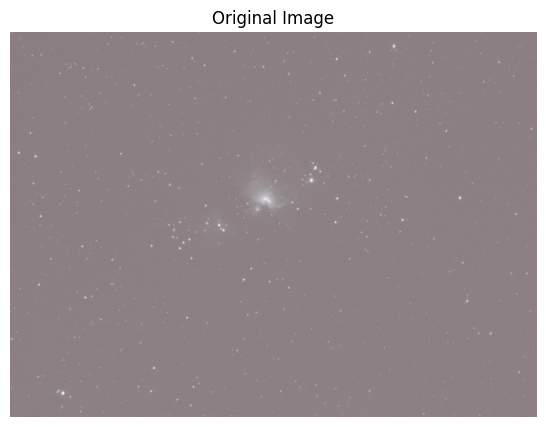

In [39]:
image_path = "./data/orion.png"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plot_side_by_side([image], ["Original Image"])

To extract the background, we'll segment the image using a technique called thresholding. This involves setting all pixels with intensity values above a certain threshold to foreground, and the rest to background.

To account for variations like uneven illumination and gradients across the image,, instead of using a single threshold value for the entire image, the treshold value is calculated based on the mean intensity of the local neighborhood surrounding each pixel. The assumption is that smaller regions within the image are more likely to have uniform characteristics. 

It's important for the size of the neighborhood to be large enough to include an adequate mix of foreground and background pixels, otherwise an inaccurate threshold is chosen. On the other hand, if the neighborhood is too large the assumption of uniformity across the region is violated.

In [40]:
def get_tresholded_image(image, kernel_size=180, treshold=3):

    input_image = image.copy()
    gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    # Apply mean filtering to get local mean
    mean_filtered_image = cv2.blur(gray_image, (kernel_size, kernel_size))
    # Apply thresholding based on mean filtering.
    # A constant value (threshold) is added to the mean of local intensity values.
    # This adjustment helps differentiate pixels in uniform neighborhoods, setting them to background.
    tresholded_image = np.where(gray_image > mean_filtered_image + treshold, 1, 0).astype('uint8')
    # Apply dilation to enhance the regions
    dilation_kernel = np.ones((3, 3), np.uint8)
    dilated_image = cv2.dilate(tresholded_image, dilation_kernel, iterations=1) 
    return dilated_image

Comparison between different treshold values.

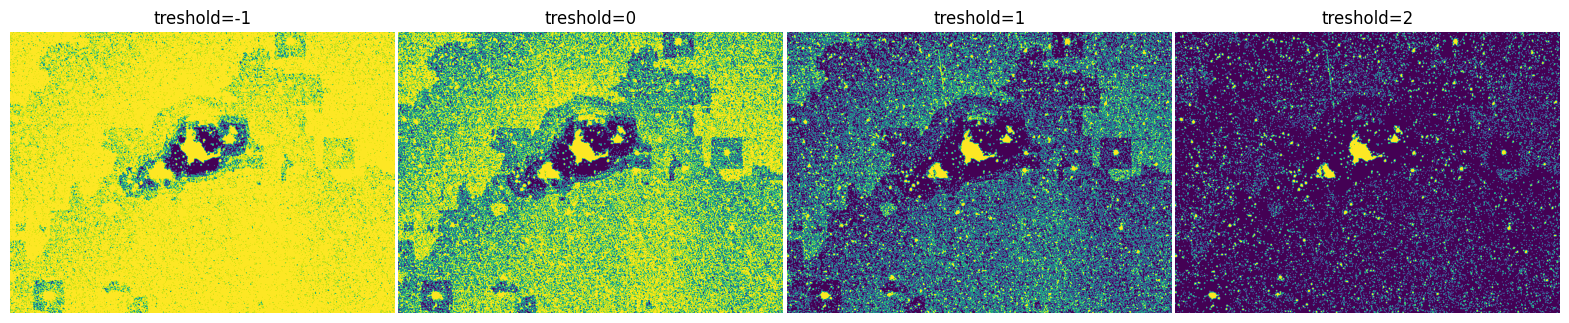

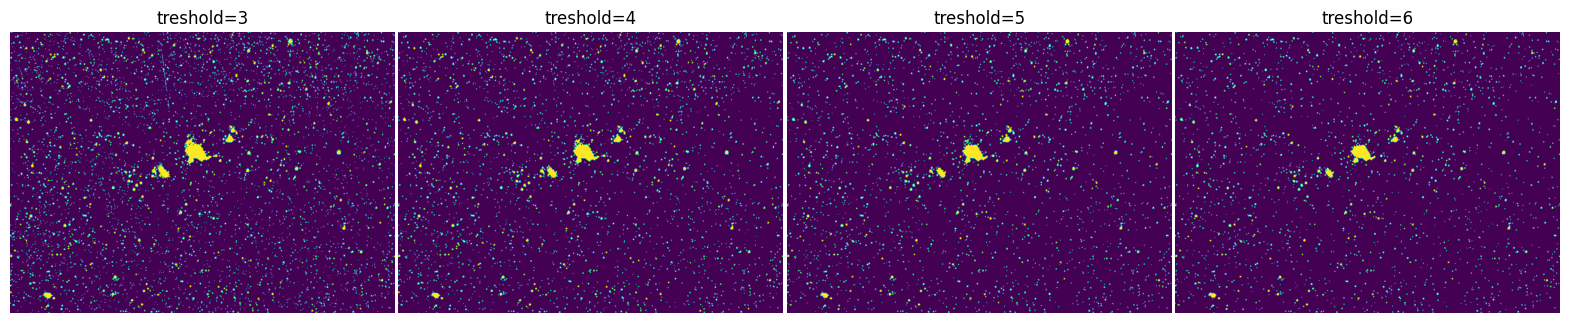

In [41]:
images = []
titles = []
for treshold in range(-1,7,1):
    tresholded_image = get_tresholded_image(image, treshold=treshold)
    images.append(tresholded_image)
    title = f"treshold={treshold}"
    titles.append(title)

images_per_row = 4
for i in range(0, len(images), images_per_row):
    plot_side_by_side(images[i:i+images_per_row], titles[i:i+images_per_row])

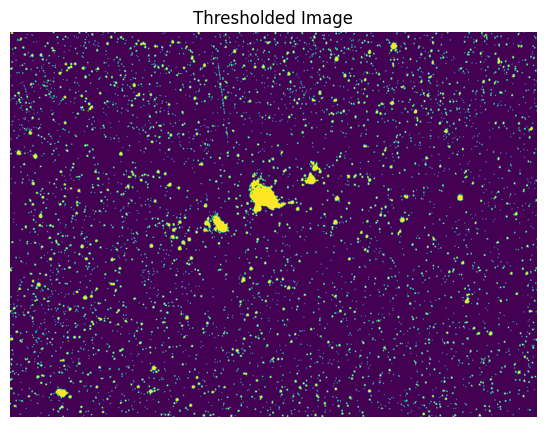

In [42]:
# Treshold image
tresholded_image = get_tresholded_image(image, kernel_size=180, treshold=3)
plot_side_by_side([tresholded_image], ["Thresholded Image"])

Once the image has been segmented, the next step is choosing sample pixels solely from the background, while excluding those from the foreground. These sample pixels will be utilized later to estimate the background of the image through interpolation.

In [43]:
def get_samples(
    image, samples_per_line, border_offset=20, sample_offset=10
):
    annotated_image = image.copy()

    tresholded_image = get_tresholded_image(image, kernel_size=90, treshold=3)
    dilated_image = cv2.dilate(
        tresholded_image, np.ones((3, 3), np.uint8), iterations=1
    )

    height, width = image.shape[0], image.shape[1]
    horizontal_sample_coordinates = np.linspace(
        0 + border_offset, width - border_offset, samples_per_line, dtype=int
    )
    vertical_sample_coordinates = np.linspace(
        0 + border_offset, height - border_offset, 10, dtype=int
    )

    samples = []
    for x in horizontal_sample_coordinates:
        for y in vertical_sample_coordinates:
            sample = find_valid_sample(dilated_image, x, y, sample_offset)
            if sample:
                samples.append(sample)
                annotated_image = cv2.circle(
                    annotated_image,
                    (sample[0], sample[1]),
                    radius=10,
                    color=(0, 255, 0),
                    thickness=2,
                )

    return np.array(samples), annotated_image


def find_valid_sample(image, x, y, sample_offset):
    delta_values = [-sample_offset, 0, sample_offset]
    for dx in delta_values:
        for dy in delta_values:
            if image[y + dy, x + dx] == 0:
                return [x + dx, y + dy]

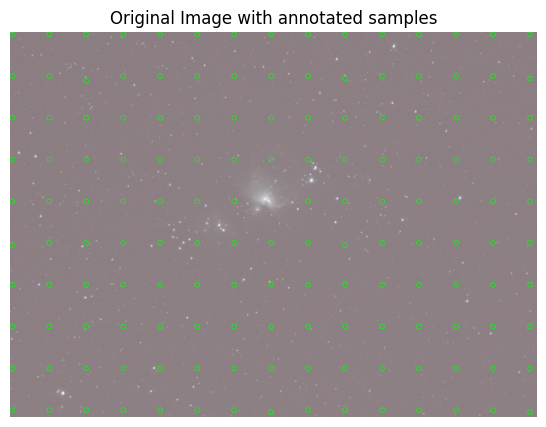

In [44]:
# Generate sample data
samples, annotated_image = get_samples(image, 15)
plot_side_by_side([annotated_image], ["Original Image with annotated samples"])

In [45]:
def get_sample_pixel_data(samples, image):
    x, y = samples.T
    if image.ndim == 3:
        pixel_values = image[y, x]
    else:
        pixel_values = image[y, x][:, np.newaxis]
    return np.hstack([samples, pixel_values])


def poly_surface(xy, A, B, C, D, E, F, G, H, I, J):
    x, y = xy
    return (A * x**3) + (B * y**3) + (C * x**2 * y) + (D * x * y**2) + (E * x**2) + (F * y**2) + (G * x * y) + (H * x) + (I * y) + J


def fit_data_to_surface(x_values, y_values, z_values, x_mesh, y_mesh, noise_scale):
    # Fit the data to the polynomial surface
    coefficients, _ = curve_fit(poly_surface, (x_values, y_values), z_values)
    # Generate fitted surface
    z_fit = poly_surface((x_mesh, y_mesh), *coefficients) 
    # Add noise to the fitted surface
    noise = noise_scale  * np.random.randn(*z_fit.shape)
    z_fit_with_noise = z_fit + noise
    return z_fit_with_noise, coefficients

pixel_data = get_sample_pixel_data(samples, image)
x, y, r, g, b = pixel_data.T

# Evaluate the fitted surface at new points
height, width, _ = image.shape
x_new = np.arange(0, width, 1, dtype=float)
y_new = np.arange(0, height, 1, dtype=float)
x_mesh, y_mesh = np.meshgrid(x_new, y_new)

Representing continuous data limited precision to represent continuous data, such as with uint8, can cause abrupt and unnatural transitions between colors or shades known as posterization. Adding random noise can smooth these transitions by introducing subtle gradients and variations that make the transitions between colors smoother.

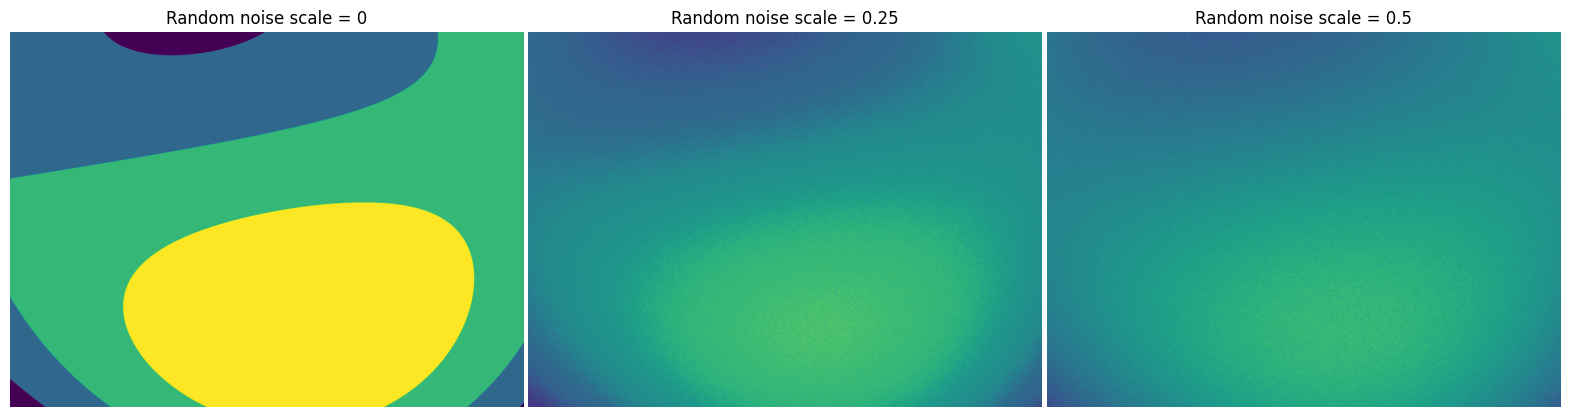

In [46]:
z = r
images = []
titles = []
for noise_scale in [0, 0.25, 0.5]:
    z_fit, _ = fit_data_to_surface(x, y, z, x_mesh, y_mesh, noise_scale=noise_scale)
    images.append(z_fit.astype('uint8'))
    titles.append(f"Random noise scale = {noise_scale}")

plot_side_by_side(images, titles)

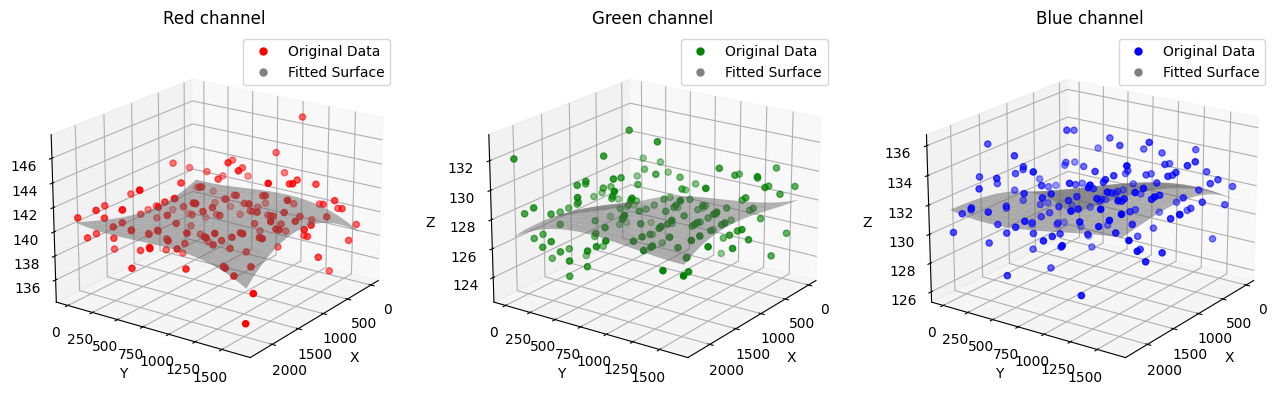

In [47]:
fig = plt.figure(figsize=(16, 5))
channel_coefficients = []
channel_names = ["red","green","blue"]

for i, (z, channel_name) in enumerate(zip([r,g,b],channel_names)):
    z_fit, coefficients = fit_data_to_surface(x, y, z, x_mesh, y_mesh, noise_scale=0)
    channel_coefficients.append(coefficients)

    original_data_color = channel_name
    fitted_surface_color = "grey"
    
    ax = fig.add_subplot(1, 3, i + 1, projection="3d")
    ax.scatter(x, y, z, label="Original Data", color=original_data_color)
    ax.view_init(elev=20.0, azim=35, roll=0)
    ax.plot_surface(
        x_mesh,
        y_mesh,
        z_fit,
        alpha=0.5,
        rstride=100,
        cstride=100,
        color=fitted_surface_color,
        label="Fitted Surface",
    )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    # Create custom legend
    legend_elements = [
        Line2D(
            [0],
            [0],
            color=original_data_color,
            marker="o",
            linestyle="None",
            markersize=5,
            label="Original Data",
        ),
        Line2D(
            [0],
            [0],
            color=fitted_surface_color,
            marker="o",
            linestyle="None",
            markersize=5,
            label="Fitted Surface",
        ),
    ]
    ax.legend(handles=legend_elements)
    ax.set_title(f'{channel_name.title()} channel')

plt.show()

In [48]:
for coefficients, channel_name in zip(channel_coefficients, channel_names):    
# Display the coefficients
    print(f"{channel_name.title()} channel coefficients:")
    for i, j in zip(coefficients, ascii_uppercase):
        print(f"{j} = {i:.3f}")

Red channel coefficients:
A = -0.000
B = -0.000
C = -0.000
D = 0.000
E = 0.000
F = 0.000
G = 0.000
H = -0.002
I = -0.000
J = 139.643
Green channel coefficients:
A = -0.000
B = 0.000
C = -0.000
D = -0.000
E = 0.000
F = -0.000
G = 0.000
H = 0.000
I = 0.004
J = 125.078
Blue channel coefficients:
A = 0.000
B = -0.000
C = 0.000
D = 0.000
E = -0.000
F = 0.000
G = -0.000
H = 0.005
I = 0.004
J = 127.264


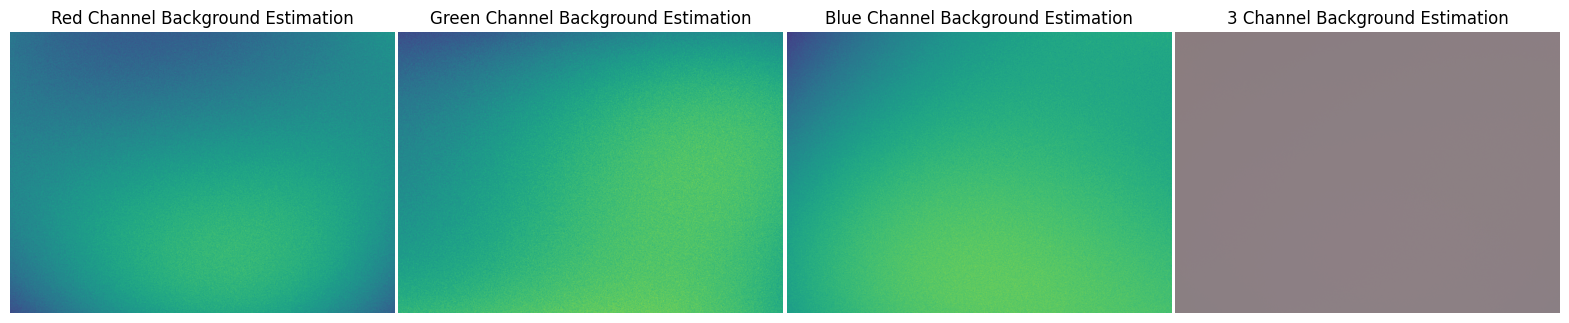

In [49]:
def compute_background_estimation(samples, image):
    pixel_data = get_sample_pixel_data(samples, image)

    height, width, _ = image.shape
    x, y, r, g, b = pixel_data.T
    x_img = np.arange(0, width, 1, dtype=float)
    y_img = np.arange(0, height, 1, dtype=float)
    x_img, y_img = np.meshgrid(x_img, y_img)
    background_estimation = []
    for z in [r, g, b]:
        z_fit, _ = fit_data_to_surface(x, y, z, x_img, y_img, noise_scale=0.5)
        background_estimation.append(z_fit)

    return np.stack(background_estimation, axis=-1).astype('uint8')

background_estimation = compute_background_estimation(samples, image)
per_channel_images = np.split(background_estimation, 3, axis=2)
images = per_channel_images + [background_estimation]
titles = [f"{channel_name.title()} Channel Background Estimation" for channel_name in channel_names] + ["3 Channel Background Estimation"]
plot_side_by_side(images, titles)


The final step involves subtracting the estimated background from the original image.

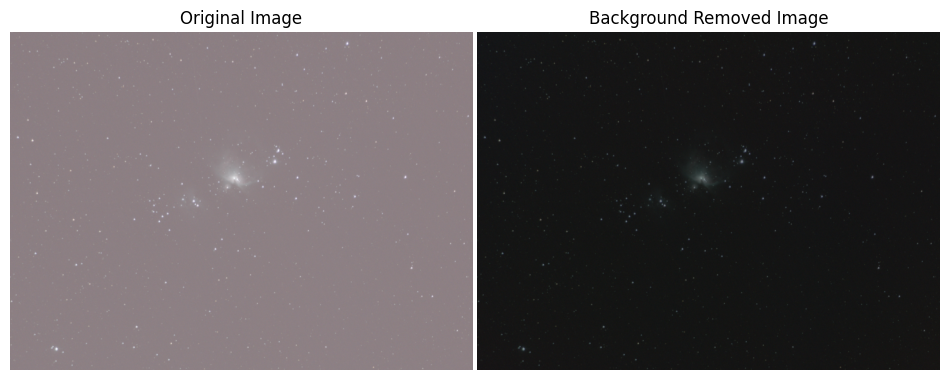

In [50]:
def remove_background(image, background, offset=0):
    diff_image = image.astype("int16") - background.astype("int16") + offset
    diff_image = np.where(diff_image < 0, 0, diff_image)
    return diff_image

background_removed_image = remove_background(image, background_estimation, 20)

plot_side_by_side(
    [image, background_removed_image],
    ["Original Image", "Background Removed Image"],
    figsize=(12, 6),
)